In [1]:
import numpy as np

In [2]:
def simulate_gbm(S0, mu, sigma, T, N, n_paths, leverage):
    # simulate n_paths many paths from 0 to T of GBM with parameters mu and sigma
    dt = T / N
    times = np.linspace(0, T, N + 1)

    Z = np.random.randn(n_paths, N)

    drift = mu - (1 / 2) * (sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z

    logS = np.zeros((n_paths, N + 1))
    logS[:, 0] = np.log(S0)
    logS[:, 1:] = np.cumsum(drift + diffusion, axis=1) + logS[:, :1]

    # leveraged log-returns
    logL = np.zeros((n_paths, N + 1))
    logL[:, 0] = logS[:, 0]
    logL[:, 1:] = (
        np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)
        + logL[:, :1]
    )

    S_end = np.exp(logS[:, N])
    L_end = np.exp(logL[:, N])
    L_end[np.isnan(L_end)] = 0

    return L_end - S_end

In [3]:
diff = simulate_gbm(1, 0.01, 0.02, 100, 100, 1000, 2)

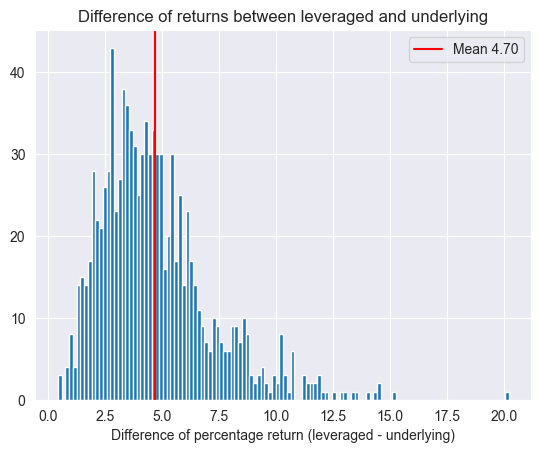

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

plt.figure()
plt.title(f"Difference of returns between leveraged and underlying")
plt.xlabel(f"Difference of percentage return (leveraged - underlying)")
mean = diff.mean()
plt.axvline(x=mean, label=f"Mean {mean:.2f}", color="red")
plt.hist(diff, bins=120)

plt.legend()
plt.show()

In [ ]:
import itertools


# expirations = days to expiration
# update_times = time between updates in units of days (half-hour, day, minutes)
# factors = leverage factors
def plot_comparison(
    mus=[0],
    sigmas=[0.02],
    expirations=[5],
    daily_frequencies=[13],
    factors=[2],
    n_paths=1000,
):
    plt.figure()

    for mu, sigma, T, freq, factor in itertools.product(
        mus, sigmas, expirations, daily_frequencies, factors
    ):
        difference = simulate_gbm(1, mu, sigma, T, T * freq, n_paths, factor)
        plt.hist(
            difference,
            bins=100,
            alpha=0.5,
            label=f"duration = {T} \nfactor = {factor} \nfrequency = {freq} \nmedian = {np.median(difference):.2f} \nmean = {difference.mean():.2f} \nstd = {difference.std():.2f}",
        )

    plt.xlabel(f"Difference of lETF - asset percentage returns")
    plt.legend()
    plt.show()

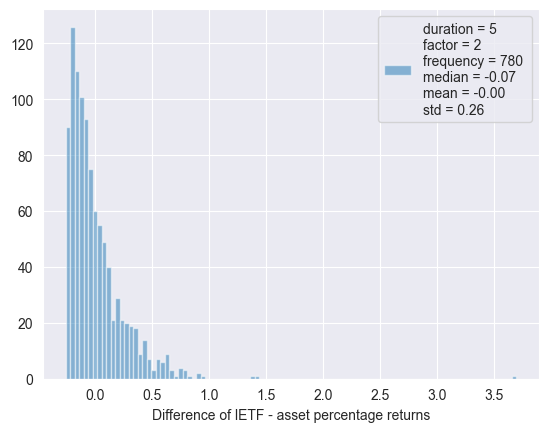

In [ ]:
expirations = [5, 10, 21, 100, 200]
daily_frequencies = [780, 13, 1]
factors = [2, 3, 5]

plot_comparison(sigmas=[0.1], daily_frequencies=[780])

In [ ]:
def mean_diff(S0, mu, sigma, T, N, n_paths, leverage):
    return simulate_gbm(S0, mu, sigma, T, int(N), n_paths, leverage).mean()


def plot_heat_factor_frequency(mu=0, sigma=0.02, T=5, n_paths=10):
    freq, factor = np.meshgrid(np.linspace(1, 46800, 100), np.linspace(1, 5, 10))

    diff = np.vectorize(mean_diff)(1, mu, sigma, T, T * freq, n_paths, factor)

    plt.figure()
    plt.contourf(freq, factor, diff, cmap="coolwarm")
    plt.title("Average percentage difference lETF - underlying")
    plt.xlabel("Daily frequency")
    plt.ylabel("Leverage factor")
    plt.colorbar()

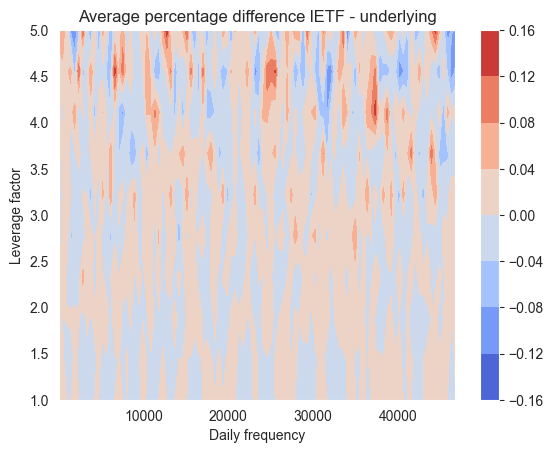

In [11]:
plot_heat_factor_frequency()